## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]


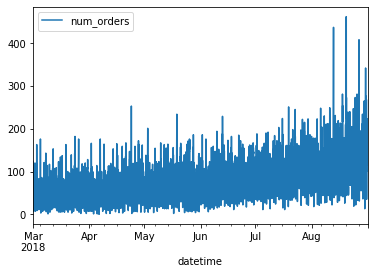

In [3]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.plot()
print(data)stssa

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


# 2. Анализ

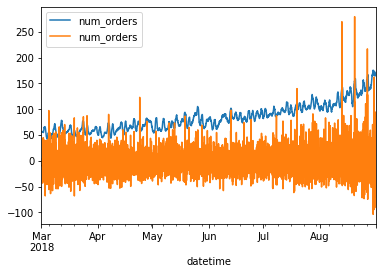

In [2]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(ax=plt.gca())
decomposed.resid.plot(ax=plt.gca())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
num_orders    4416 non-null int64
mean          4393 non-null float64
dtypes: float64(1), int64(1)
memory usage: 103.5 KB
None


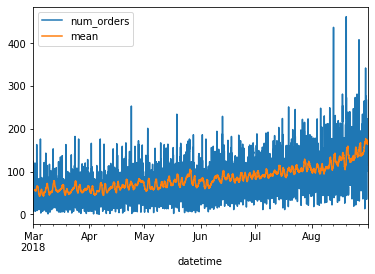

In [3]:
data['mean'] = data.rolling(24).mean()
data.plot()
print(data.info())

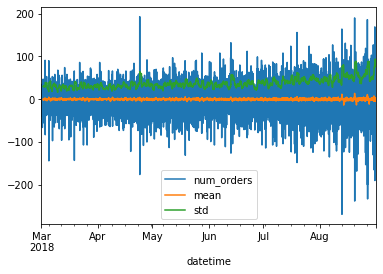

In [4]:
data_s = data - data.shift()
data_s['std'] = data_s['num_orders'].rolling(24).std()
data_s.plot()

Считаем разность соседних временных и рядов и получаем, что ряд стационарный - значит можно предсказывать временные ряды

# 3. Обучение

In [5]:
data = data.drop(['mean'],axis=1)

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hourofday'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

model = LinearRegression()   
    
for lag in range(1,10,1):
    for rolling in range(1,10,1):
        make_features(data, lag, rolling)

        train_ds, test = train_test_split(data, shuffle=False, test_size=0.1)
        train, valid = train_test_split(train_ds, shuffle=False, test_size=0.1)
        train = train.dropna()
        
         

        train_1 = train.drop(['num_orders'],axis=1)
        train_2 = train['num_orders']

        test_1 = test.drop(['num_orders'],axis=1)
        test_2 = test['num_orders']
        
        valid_1 = valid.drop(['num_orders'],axis=1)
        valid_2 = valid['num_orders']

        model.fit(train_1,train_2)

        pred = model.predict(test_1)
        pred_valid = model.predict(valid_1)
        
        print('shift:',lag)
        print('rolling:',rolling)
        print("RMSE тестовой выборки при Линейной Регрессии:", np.sqrt(mean_absolute_error(test_2 , pred)))
        print("RMSE валидной выборки при Линейной Регрессии:", np.sqrt(mean_absolute_error(valid_2 , pred_valid)))
        print('-------------')

shift: 1
rolling: 1
RMSE тестовой выборки при Линейной Регрессии: 6.372141667957806
RMSE валидной выборки при Линейной Регрессии: 5.521203048973097
-------------
shift: 1
rolling: 2
RMSE тестовой выборки при Линейной Регрессии: 6.381268709511109
RMSE валидной выборки при Линейной Регрессии: 5.52797523875636
-------------
shift: 1
rolling: 3
RMSE тестовой выборки при Линейной Регрессии: 6.373516070022748
RMSE валидной выборки при Линейной Регрессии: 5.523131543839371
-------------
shift: 1
rolling: 4
RMSE тестовой выборки при Линейной Регрессии: 6.362126525455162
RMSE валидной выборки при Линейной Регрессии: 5.507461911078613
-------------
shift: 1
rolling: 5
RMSE тестовой выборки при Линейной Регрессии: 6.3665581881730136
RMSE валидной выборки при Линейной Регрессии: 5.501785869438494
-------------
shift: 1
rolling: 6
RMSE тестовой выборки при Линейной Регрессии: 6.380114935666638
RMSE валидной выборки при Линейной Регрессии: 5.4981403661552
-------------
shift: 1
rolling: 7
RMSE тесто

In [6]:
for depth in range(10,40,10):
    for tree in range(1,15,7):
        model_forest = RandomForestRegressor(n_estimators=tree, max_depth=depth, random_state = 123)
        for lag in range(1,10,1):
            for rolling in range(1,10,1):
                make_features(data, lag, rolling)
    
                train_ds, test = train_test_split(data, shuffle=False, test_size=0.1)
                train, valid = train_test_split(train_ds, shuffle=False, test_size=0.1)
                train = train.dropna()

                train_1 = train.drop(['num_orders'],axis=1)
                train_2 = train['num_orders']

                test_1 = test.drop(['num_orders'],axis=1)
                test_2 = test['num_orders']
                
                valid_1 = valid.drop(['num_orders'],axis=1)
                valid_2 = valid['num_orders']

                model_forest.fit(train_1,train_2)

                pred_forest = model_forest.predict(test_1)
                pred_valid = model_forest.predict(valid_1)
        
                print('shift:',lag)
                print('rolling:',rolling)
                print('depth:',depth)
                print('tree:',tree)
                print("RMSE тестовой выборки при Случайном лесе:", np.sqrt(mean_absolute_error(test_2 , pred_forest)))
                print("RMSE тестовой выборки при Случайном лесе:", np.sqrt(mean_absolute_error(valid_2 , pred_valid)))
                print('-------------')

shift: 1
rolling: 1
depth: 10
tree: 1
RMSE тестовой выборки при Случайном лесе: 6.268821987287498
RMSE тестовой выборки при Случайном лесе: 5.436348812326372
-------------
shift: 1
rolling: 2
depth: 10
tree: 1
RMSE тестовой выборки при Случайном лесе: 6.314132153740964
RMSE тестовой выборки при Случайном лесе: 5.419074594924522
-------------
shift: 1
rolling: 3
depth: 10
tree: 1
RMSE тестовой выборки при Случайном лесе: 6.296379600740807
RMSE тестовой выборки при Случайном лесе: 5.6938706955969
-------------
shift: 1
rolling: 4
depth: 10
tree: 1
RMSE тестовой выборки при Случайном лесе: 6.235742059521416
RMSE тестовой выборки при Случайном лесе: 5.686319808836458
-------------
shift: 1
rolling: 5
depth: 10
tree: 1
RMSE тестовой выборки при Случайном лесе: 6.255407849823469
RMSE тестовой выборки при Случайном лесе: 5.244012855197175
-------------
shift: 1
rolling: 6
depth: 10
tree: 1
RMSE тестовой выборки при Случайном лесе: 6.368358340810201
RMSE тестовой выборки при Случайном лесе: 5.